In [1]:
import pickle as pkl
import random
import sys
import warnings
from collections import OrderedDict
from glob import glob
from pathlib import Path
from time import time
from typing import Callable, Dict, Optional, Tuple

import brevitas
import brevitas.nn as qnn
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from brevitas import config
from brevitas.quant import Int8ActPerTensorFloat, Int8WeightPerTensorFloat
from concrete.fhe.compilation import Configuration
from sklearn.metrics import top_k_accuracy_score
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

from concrete.ml.torch.compile import compile_brevitas_qat_model, compile_torch_model

warnings.filterwarnings("ignore", category=UserWarning)


from cifar_utils import (
    fhe_compatibility,
    get_dataloader,
    mapping_keys,
    plot_baseline,
    plot_dataset,
    torch_inference,
    train,
)

/home/celia/Desktop/Zama/concrete-internal/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [18]:
INPUT_IMG_SIZE = 28
NB_LAYER       = 100

<!> Since MNIST is a relatively simple task, training a floating-point model and then fine-tuning the quantized model yields the same results as training the quantized model from scratch.

- If we train first the FP32, then assign the weights to the Brevitas model, and finally finetune it, we save like  10 epochs 

<!> That's why the following cell is disabled.

In [19]:
FEATURES_MAPS = [
    ("I",),
    # Layer 1: INPUT_IMG_SIZE, out_size, kernel_size=t[3], stride=t[4], padding=t[5], padding_mode="replicate")
    ("C", 1, 1, 3, 0, 1, "replicate"),
]

LINEAR_LAYERS = (
    [("R",), ("L", INPUT_IMG_SIZE * INPUT_IMG_SIZE, 92),  ("I",), ("B", 92), ("I",),] + \
    [("R",), ("L", 92, 92),  ("I",), ("B", 92), ("I",),] * (NB_LAYER - 2) + [("L", 92, 10)]
)


class ReplicatePad2d(nn.Module):
    def __init__(self, padding, mode):
        super(ReplicatePad2d, self).__init__()
        self.padding = padding  # padding is expected as a tuple (left, right, top, bottom)
        self.mode = mode

    def forward(self, x):
        return nn.functional.pad(x, self.padding, mode=self.mode)

In [20]:
class Fp32MNIST(nn.Module):
    def __init__(self, output_size: int):
        super(Fp32MNIST, self).__init__()
        """ Torch model.

        Args:
            output_size (int): Number of classes.
        """
        self.output_size = output_size

        def make_layers(t):

            if t[0] == "P":
                return ReplicatePad2d(t[1], t[2])
            elif t[0] == "C":
                return nn.Conv2d(1, 1, kernel_size=3, stride=1)
            elif t[0] == "L":
                return nn.Linear(in_features=t[1], out_features=t[2])
            elif t[0] == "R":
                return nn.ReLU()
            elif t[0] == "F":
                return nn.Flatten(1, -1)
            elif t[0]:
                return nn.BatchNorm1d(t[1])
            else:
                raise NameError(f"{t} not defined")

        self.features_maps = nn.Sequential(*[make_layers(t) for t in FEATURES_MAPS if t[0] != "I"])
        self.linears = nn.Sequential(*[make_layers(t) for t in LINEAR_LAYERS if t[0] != "I"])

    def forward(self, x):
        x = self.features_maps(x)
        x = nn.Flatten()(x)
        x = self.linears(x)
        return x

In [21]:
class QuantMNIST(nn.Module):
    def __init__(
        self,
        bit: int,
        output_size: int = 10,
        act_quant: brevitas.quant = Int8ActPerTensorFloat,
        weight_quant: brevitas.quant = Int8WeightPerTensorFloat,
    ):
        """A quantized network with Brevitas.

        Args:
            bit (int): Bit of quantization.
            output_size (int): Number of classes.
            act_quant (brevitas.quant): Quantization protocol of activations.
            weight_quant (brevitas.quant): Quantization protocol of the weights.

        """
        super(QuantMNIST, self).__init__()
        self.bit = bit

        def tuple2quantlayer(t):
            if t[0] == "R":
                return qnn.QuantReLU(return_quant_tensor=True, bit_width=bit, act_quant=act_quant)
            if t[0] == "C":
                return qnn.QuantConv2d(
                    t[1],
                    t[2],
                    kernel_size=t[3],
                    #stride=t[4],
                    weight_bit_width=2,
                    weight_quant=weight_quant,
                    return_quant_tensor=True,
                )
            if t[0] == "L":
                return qnn.QuantLinear(
                    in_features=t[1],
                    out_features=t[2],
                    weight_bit_width=bit,
                    weight_quant=weight_quant,
                    bias=True,
                    return_quant_tensor=True,
                )
            if t[0] == "I":
                identity_quant = t[1] if len(t) == 2 else bit
                return qnn.QuantIdentity(
                    bit_width=identity_quant, act_quant=act_quant, return_quant_tensor=True
                )
            if t[0] == "B":
                return nn.BatchNorm1d(t[1])

        self.features_maps = nn.Sequential(
            *[tuple2quantlayer(t) for t in FEATURES_MAPS if t[0] != "I"]
        )

        # self.identity1 and self.identity2 are used to encapsulate the `torch.flatten`.
        self.identity1 = qnn.QuantIdentity(
            bit_width=bit, act_quant=act_quant, return_quant_tensor=True
        )

        self.identity2 = qnn.QuantIdentity(
            bit_width=bit, act_quant=act_quant, return_quant_tensor=True
        )

        self.linears = nn.Sequential(*[tuple2quantlayer(t) for t in LINEAR_LAYERS if t[0] != "I"])

    def forward(self, x):
        x = self.features_maps(x)
        x = self.identity1(x)
        x = torch.flatten(x, 1)
        x = self.identity2(x)
        x = self.linears(x)
        return x.value

Train the model

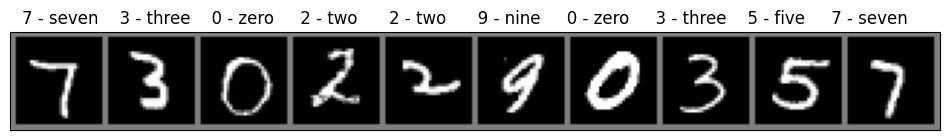

(torch.Size([64, 1, 30, 30]), './checkpoints/MNIST/NLP_100')

In [22]:
param = {
    "output_size": 10,
    "batch_size": 64,
    "dataset_name": "MNIST",
    "dataset": datasets.MNIST,
    "dir": f"./checkpoints/MNIST/NLP_{NB_LAYER}",
    "training": "fp32",
    "criterion": torch.nn.CrossEntropyLoss(),
    "accuracy_test": [],
    "accuracy_train": [],
    "loss_test_history": [],
    "loss_train_history": [],
    "seed": 42,
}

device =  "cpu"

train_loader, test_loader = get_dataloader(param=param)

data_calibration = next(iter(train_loader))[0]

plot_dataset(test_loader, param)

data_calibration.shape, param['dir']

In [50]:
fp32_mnist = Fp32MNIST(param['output_size']).to(device)

checkpoint = torch.load(
        f"./checkpoints/MNIST/NLP_50/fp32/MNIST_fp32_state_dict.pt",
        map_location=device
        )

new_dict = fp32_mnist.state_dict()

for name in checkpoint:
    if name in new_dict and checkpoint[name].size() == new_dict[name].size():
        new_dict[name].copy_(checkpoint[name])

for n, p in list(fp32_mnist.named_parameters())[0: 98]:
        p.requires_grad = False

#torch_inference(fp32_mnist, test_loader, device=device), torch_inference(fp32_mnist, train_loader, device=device)

In [51]:
# Instantiation of the custom VGG-11 network.

run = 1


if run:
    param["training"] = "fp32"
    param["epochs"] = 1
    param["lr"] = 0.001
    param["milestones"] = [2]
    param["gamma"] = 0.1

    fp32_mnist = train(fp32_mnist, train_loader, test_loader, param, device=device)

Epoch  0: Train loss = 1.6092 VS Test loss = 1.3931 - Accuracy train: 0.4291 VS Accuracy test: 0.5961
100%|██████████| 1/1 [00:41<00:00, 41.27s/it]
Save in: checkpoints/MNIST/NLP_100/fp32/MNIST_fp32_state_dict.pt


In [17]:
# Instantiation of the custom VGG-11 network.
fp32_mnist = Fp32MNIST(param['output_size']).to(device)

# Sanity check
checkpoint = torch.load(f"./checkpoints/MNIST/NLP_50/fp32/MNIST_fp32_state_dict.pt", map_location=device)

fp32_mnist.load_state_dict(checkpoint)

# for name in mnist_nlp20:
#     if name in mnist_nlp50 and mnist_nlp20[name].size() == mnist_nlp50[name].size():
#         mnist_nlp50[name].copy_(mnist_nlp20[name])

# fp32_mnist.load_state_dict(checkpoint)

# for n, p in list(fp32_mnist.named_parameters())[0: 47]:
#         p.requires_grad = False

torch_inference(fp32_mnist, test_loader, device=device), torch_inference(fp32_mnist, train_loader, device=device)

(0.9685496794871795, 0.980739727854856)

In [8]:
# Instantiation of the custom VGG-11 network.

run = False

fp32_mnist = Fp32MNIST(param['output_size']).to(device)

if run:
    param["training"] = "fp32"
    param["epochs"] = 30
    param["lr"] = 0.01
    param["milestones"] = [15, 24]
    param["gamma"] = 0.1

    fp32_mnist = train(fp32_mnist, train_loader, test_loader, param, device=device)

Epoch  0: Train loss = 0.6650 VS Test loss = 0.5419 - Accuracy train: 0.7971 VS Accuracy test: 0.8859
Epoch  1: Train loss = 0.3863 VS Test loss = 0.3187 - Accuracy train: 0.9059 VS Accuracy test: 0.9206
Epoch  2: Train loss = 0.2996 VS Test loss = 0.4548 - Accuracy train: 0.9283 VS Accuracy test: 0.9050
Epoch  3: Train loss = 0.2683 VS Test loss = 0.5307 - Accuracy train: 0.9369 VS Accuracy test: 0.8632
Epoch  4: Train loss = 0.2703 VS Test loss = 0.2626 - Accuracy train: 0.9358 VS Accuracy test: 0.9562
Epoch  5: Train loss = 0.2228 VS Test loss = 0.2361 - Accuracy train: 0.9484 VS Accuracy test: 0.9625
Epoch  6: Train loss = 0.2047 VS Test loss = 0.2350 - Accuracy train: 0.9521 VS Accuracy test: 0.9642
Epoch  7: Train loss = 0.2016 VS Test loss = 0.1999 - Accuracy train: 0.9522 VS Accuracy test: 0.9585
Epoch  8: Train loss = 0.1762 VS Test loss = 0.1687 - Accuracy train: 0.9576 VS Accuracy test: 0.9690
Epoch  9: Train loss = 0.1819 VS Test loss = 0.1779 - Accuracy train: 0.9567 VS Ac

In [78]:
# Sanity check
checkpoint_fp32 = torch.load(f"{param['dir']}/fp32/MNIST_fp32_state_dict.pt", map_location=device)

fp32_mnist = Fp32MNIST(param['output_size']).to(device)

fp32_mnist.load_state_dict(checkpoint_fp32)

torch_inference(fp32_mnist, test_loader, device=device), torch_inference(fp32_mnist, train_loader, device=device), list(checkpoint_fp32.keys())[:10]

(0.9685496794871795,
 0.9802561366061899,
 ['features_maps.0.weight',
  'features_maps.0.bias',
  'linears.1.weight',
  'linears.1.bias',
  'linears.2.weight',
  'linears.2.bias',
  'linears.2.running_mean',
  'linears.2.running_var',
  'linears.2.num_batches_tracked',
  'linears.4.weight'])

In [ ]:
bits = 4
run = False

quant_mnist = QuantMNIST(bit=bits, output_size=param["output_size"]).to("cpu")

quant_mnist = mapping_keys(checkpoint_fp32, quant_mnist, device="cpu")

acc_before_ft = torch_inference(quant_mnist, test_loader, device=device)

print(f"Top 1 accuracy before fine-tuning = {acc_before_ft * 100:.4f}%")

qmodel = fhe_compatibility(quant_mnist, data_calibration, rounding_threshold_bits=bits)

print(f"Maximum bit-width in the circuit: {qmodel.fhe_circuit.graph.maximum_integer_bit_width()}")

if run:
    param["training"] = f"quant_mnist_{bits=}"
    param["epochs"] = 5
    param["lr"] = 0.1
    param["milestones"] = [1, 3]
    param["gamma"] = 0.1

    quant_mnist = train(quant_mnist, train_loader, test_loader, param, device=device)



# Sanity check
quant_path = f"checkpoints/MNIST/NLP_20/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"
checkpoint_quant = torch.load(quant_path, map_location=device)

quant_mnist = QuantMNIST(bit=bits, output_size=param["output_size"]).to("cpu")

quant_mnist.load_state_dict(checkpoint_quant)

torch_inference(quant_mnist, test_loader, device=device), torch_inference(quant_mnist, train_loader, device=device), list(checkpoint_quant.keys())[:10]

In [25]:
bits = 3
run = True

quant_mnist = QuantMNIST(bit=bits, output_size=param["output_size"]).to("cpu")

quant_mnist = mapping_keys(checkpoint_fp32, quant_mnist, device="cpu")

acc_before_ft = torch_inference(quant_mnist, test_loader, device=device)

print(f"Top 1 accuracy before fine-tuning = {acc_before_ft * 100:.4f}%")

qmodel = fhe_compatibility(quant_mnist, data_calibration, rounding_threshold_bits=bits)

print(f"Maximum bit-width in the circuit: {qmodel.fhe_circuit.graph.maximum_integer_bit_width()}")

if run:
    param["training"] = f"quant_mnist_{bits=}"
    param["epochs"] = 9
    param["lr"] = 0.1
    param["milestones"] = [3]
    param["gamma"] = 0.1
    quant_mnist = train(quant_mnist, train_loader, test_loader, param, device=device)

# Sanity check
quant_path = f"checkpoints/MNIST/NLP_20/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"
checkpoint_quant = torch.load(quant_path, map_location=device)

mnist_q3 = QuantMNIST(bit=bits, output_size=param["output_size"]).to("cpu")
mnist_q3.load_state_dict(checkpoint_quant)
torch_inference(mnist_q3, test_loader, device=device), torch_inference(mnist_q3, train_loader, device=device), list(checkpoint_quant.keys())[:10]

Top 1 accuracy before fine-tuning = 9.7456%
Maximum bit-width in the circuit: 10
Epoch  0: Train loss = 0.8962 VS Test loss = 0.5770 - Accuracy train: 0.7766 VS Accuracy test: 0.8733
Epoch  1: Train loss = 0.6572 VS Test loss = 0.3646 - Accuracy train: 0.8556 VS Accuracy test: 0.9231
Epoch  2: Train loss = 0.6336 VS Test loss = 0.3999 - Accuracy train: 0.8639 VS Accuracy test: 0.9060
Epoch  3: Train loss = 0.3389 VS Test loss = 0.1920 - Accuracy train: 0.9243 VS Accuracy test: 0.9558
Epoch  4: Train loss = 0.2886 VS Test loss = 0.1941 - Accuracy train: 0.9343 VS Accuracy test: 0.9549
Epoch  5: Train loss = 0.2752 VS Test loss = 0.1743 - Accuracy train: 0.9378 VS Accuracy test: 0.9615
Epoch  6: Train loss = 0.2557 VS Test loss = 0.1648 - Accuracy train: 0.9404 VS Accuracy test: 0.9627
Epoch  7: Train loss = 0.2404 VS Test loss = 0.1630 - Accuracy train: 0.9445 VS Accuracy test: 0.9625
Epoch  8: Train loss = 0.2296 VS Test loss = 0.1699 - Accuracy train: 0.9468 VS Accuracy test: 0.9601
1

(0.960136217948718,
 0.9626800960512273,
 ['features_maps.0.weight',
  'features_maps.0.bias',
  'identity1.act_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value',
  'identity2.act_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value',
  'linears.0.act_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value',
  'linears.1.weight',
  'linears.1.bias',
  'linears.2.weight',
  'linears.2.bias',
  'linears.2.running_mean'])

In [21]:
bits = 5
# Sanity check
quant_path = f"checkpoints/MNIST/NLP_20/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"
checkpoint_quant = torch.load(quant_path, map_location=device)
mnist_q5 = QuantMNIST(bit=bits, output_size=param["output_size"]).to("cpu")
mnist_q5.load_state_dict(checkpoint_quant)
torch_inference(mnist_q5, test_loader, device=device), torch_inference(mnist_q5, train_loader, device=device)

(0.9772636217948718, 0.9802728121664888)

In [17]:
for n_bits in [3, 4, 5, 6, 7, 8, 9, 10]:

    # With PTQ
    try:
        ptq_qmodel = compile_torch_model(
            fp32_mnist,
            data_calibration,
            n_bits=n_bits,
        )
        max_bits = ptq_qmodel.fhe_circuit.graph.maximum_integer_bit_width()
        print(f"With PTQ: {n_bits=} - {max_bits=}")
    except:
        print(f"With PTQ: {n_bits=} - cannot compile")


    # With QAT
    try:
        qat_qmodel = fhe_compatibility(quant_mnist, data_calibration, rounding_threshold_bits=n_bits)
        max_bits = qat_qmodel.fhe_circuit.graph.maximum_integer_bit_width()
        print(f"With QAT: {n_bits=} - {max_bits=}")
    except:
        print(f"With QAT: {n_bits=} - cannot compile")

    print()


With PTQ: n_bits=3 - max_bits=10
With QAT: n_bits=3 - max_bits=13

With PTQ: n_bits=4 - max_bits=13
With QAT: n_bits=4 - max_bits=13

With PTQ: n_bits=5 - max_bits=15
With QAT: n_bits=5 - max_bits=14

With PTQ: n_bits=6 - cannot compile
With QAT: n_bits=6 - max_bits=14

With PTQ: n_bits=7 - cannot compile
With QAT: n_bits=7 - max_bits=14

With PTQ: n_bits=8 - cannot compile
With QAT: n_bits=8 - max_bits=14

With PTQ: n_bits=9 - cannot compile
With QAT: n_bits=9 - max_bits=14

With PTQ: n_bits=10 - cannot compile
With QAT: n_bits=10 - max_bits=13



In [81]:

# Sanity check
n_bits = 4
quant_path = f"checkpoints/MNIST/NLP_20/quant_mnist_{bits=}/MNIST_quant_mnist_{bits=}_state_dict.pt"
checkpoint_quant = torch.load(quant_path, map_location=device)

mnist_q3 = QuantMNIST(bit=bits, output_size=param["output_size"]).to("cpu")
mnist_q3.load_state_dict(checkpoint_quant)
torch_inference(mnist_q3, test_loader, device=device), torch_inference(mnist_q3, train_loader, device=device), list(checkpoint_quant.keys())[:10]

RuntimeError: Error(s) in loading state_dict for QuantMNIST:
	Missing key(s) in state_dict: "linears.58.weight", "linears.58.bias", "linears.59.weight", "linears.59.bias", "linears.59.running_mean", "linears.59.running_var", "linears.61.weight", "linears.61.bias", "linears.62.weight", "linears.62.bias", "linears.62.running_mean", "linears.62.running_var", "linears.64.weight", "linears.64.bias", "linears.65.weight", "linears.65.bias", "linears.65.running_mean", "linears.65.running_var", "linears.67.weight", "linears.67.bias", "linears.68.weight", "linears.68.bias", "linears.68.running_mean", "linears.68.running_var", "linears.70.weight", "linears.70.bias", "linears.71.weight", "linears.71.bias", "linears.71.running_mean", "linears.71.running_var", "linears.73.weight", "linears.73.bias", "linears.74.weight", "linears.74.bias", "linears.74.running_mean", "linears.74.running_var", "linears.76.weight", "linears.76.bias", "linears.77.weight", "linears.77.bias", "linears.77.running_mean", "linears.77.running_var", "linears.79.weight", "linears.79.bias", "linears.80.weight", "linears.80.bias", "linears.80.running_mean", "linears.80.running_var", "linears.82.weight", "linears.82.bias", "linears.83.weight", "linears.83.bias", "linears.83.running_mean", "linears.83.running_var", "linears.85.weight", "linears.85.bias", "linears.86.weight", "linears.86.bias", "linears.86.running_mean", "linears.86.running_var", "linears.88.weight", "linears.88.bias", "linears.89.weight", "linears.89.bias", "linears.89.running_mean", "linears.89.running_var", "linears.91.weight", "linears.91.bias", "linears.92.weight", "linears.92.bias", "linears.92.running_mean", "linears.92.running_var", "linears.94.weight", "linears.94.bias", "linears.95.weight", "linears.95.bias", "linears.95.running_mean", "linears.95.running_var", "linears.97.weight", "linears.97.bias", "linears.98.weight", "linears.98.bias", "linears.98.running_mean", "linears.98.running_var", "linears.100.weight", "linears.100.bias", "linears.101.weight", "linears.101.bias", "linears.101.running_mean", "linears.101.running_var", "linears.103.weight", "linears.103.bias", "linears.104.weight", "linears.104.bias", "linears.104.running_mean", "linears.104.running_var", "linears.106.weight", "linears.106.bias", "linears.107.weight", "linears.107.bias", "linears.107.running_mean", "linears.107.running_var", "linears.109.weight", "linears.109.bias", "linears.110.weight", "linears.110.bias", "linears.110.running_mean", "linears.110.running_var", "linears.112.weight", "linears.112.bias", "linears.113.weight", "linears.113.bias", "linears.113.running_mean", "linears.113.running_var", "linears.115.weight", "linears.115.bias", "linears.116.weight", "linears.116.bias", "linears.116.running_mean", "linears.116.running_var", "linears.118.weight", "linears.118.bias", "linears.119.weight", "linears.119.bias", "linears.119.running_mean", "linears.119.running_var", "linears.121.weight", "linears.121.bias", "linears.122.weight", "linears.122.bias", "linears.122.running_mean", "linears.122.running_var", "linears.124.weight", "linears.124.bias", "linears.125.weight", "linears.125.bias", "linears.125.running_mean", "linears.125.running_var", "linears.127.weight", "linears.127.bias", "linears.128.weight", "linears.128.bias", "linears.128.running_mean", "linears.128.running_var", "linears.130.weight", "linears.130.bias", "linears.131.weight", "linears.131.bias", "linears.131.running_mean", "linears.131.running_var", "linears.133.weight", "linears.133.bias", "linears.134.weight", "linears.134.bias", "linears.134.running_mean", "linears.134.running_var", "linears.136.weight", "linears.136.bias", "linears.137.weight", "linears.137.bias", "linears.137.running_mean", "linears.137.running_var", "linears.139.weight", "linears.139.bias", "linears.140.weight", "linears.140.bias", "linears.140.running_mean", "linears.140.running_var", "linears.142.weight", "linears.142.bias", "linears.143.weight", "linears.143.bias", "linears.143.running_mean", "linears.143.running_var", "linears.145.weight", "linears.145.bias", "linears.146.weight", "linears.146.bias", "linears.146.running_mean", "linears.146.running_var", "linears.147.weight", "linears.147.bias". 
	Unexpected key(s) in state_dict: "linears.57.weight", "linears.57.bias". 

In [80]:

history = {}

for thresold in tqdm([8, 7, 6, 5, 4]):
    history_yhats, history_timing = [], []
    run_in_fhe = True

    for data, labels in tqdm(test_loader):

        data, labels = data.detach().cpu().numpy(), labels.detach().cpu().numpy()

        history[thresold] = []

        qat_qmodel = compile_brevitas_qat_model(
            mnist_q3.to("cpu"),
            torch_inputset=data_calibration,
            rounding_threshold_bits=thresold,
        )

        start_time = time()
        predictions = qat_qmodel.forward(data, fhe="simulate")
        end_time = ((time() - start_time) / 60.0) / data.shape[0]

        history_yhats.extend(predictions.argmax(1) == labels)
        history_timing.append(end_time)

        if run_in_fhe:
            start_time = time()
            predictions = qat_qmodel.forward(data[0, None], fhe="execute")
            end_time = ((time() - start_time) / 60.0)
            history_timing.append(end_time)
            run_in_fhe = False
            print(history_timing)

        

    history[thresold].append([history_yhats, history_timing])

  0%|          | 0/5 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
for threshold in history.keys():
    print(
        f"{quant_mnist.bit=} - {threshold=}: accuracy = {np.mean(history[threshold][0][0]):.3f}, {np.mean(history[threshold][0][1]):.3f}"
    )